In [36]:
import os
import gc
import sys
import numpy as np 
import pandas as pd 
import seaborn as sns
from plotly import tools
import tensorflow as tf
from pathlib import Path
import keras.backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
from matplotlib import pyplot
import matplotlib.image as mplimg
from tqdm.autonotebook import tqdm
from matplotlib.pyplot import imshow
from keras.preprocessing import image
from plotly.subplots import make_subplots
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense
from keras import layers, models,regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential, load_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report 
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Cleansing Data**

In [3]:
train_df = pd.read_csv("../input/happy-whale-and-dolphin/train.csv")
#train_df=train_df.drop_duplicates(subset=['individual_id'],keep='last')
train_df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [4]:
train_df.shape

(51033, 3)

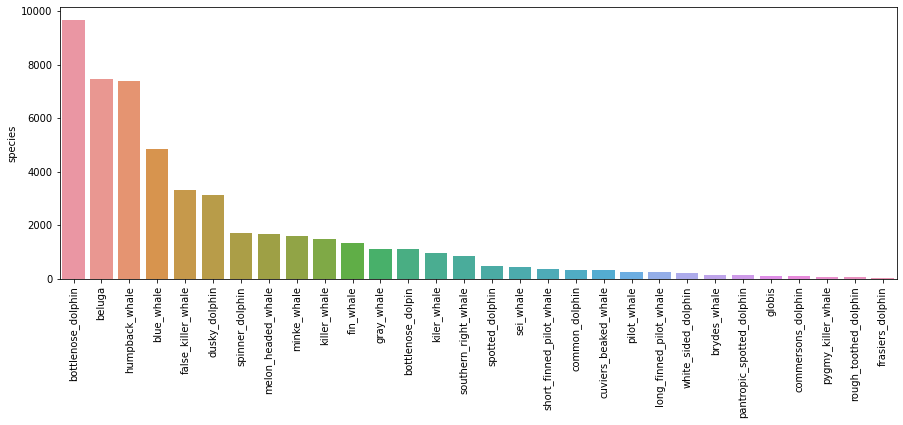

In [5]:
plt.figure(figsize=(15,5))
sns.barplot(x=train_df['species'].value_counts().index, y=train_df['species'].value_counts())
plt.xticks(rotation=90)
plt.show()

In [6]:
train_df['species'].nunique()

30

In [7]:
train_df['species'].replace({"globis": "short_finned_pilot_whale",
                              "pilot_whale": "short_finned_pilot_whale",
                              "beluga": "beluga_whale",
                              "kiler_whale": "killer_whale",
                              "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [8]:
train_df.shape

(51033, 3)

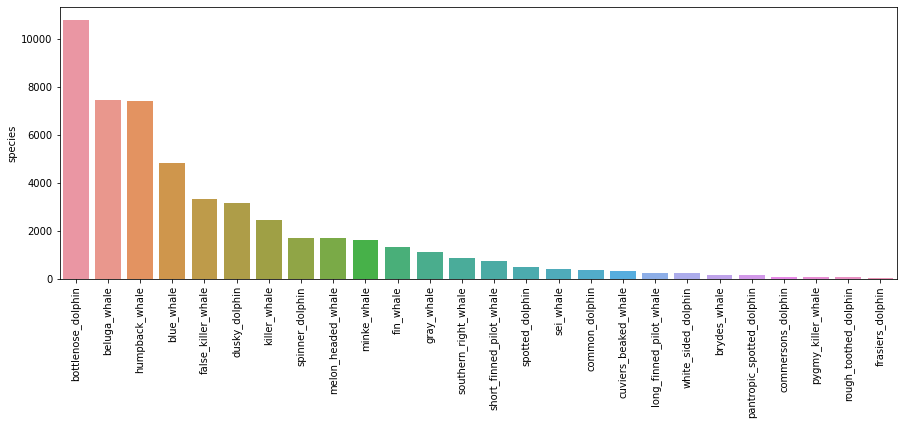

In [9]:
plt.figure(figsize=(15,5))
sns.barplot(x=train_df['species'].value_counts().index, y=train_df['species'].value_counts())
plt.xticks(rotation=90)
plt.show()

In [10]:
train_df['species'].nunique()

26

# **Functions-Load-Prepare**

In [11]:
def Loading_Images(data, m, dataset):
    print("Loading images")
    X_train = np.zeros((m, 32, 32, 3))
    count = 0
    for fig in tqdm(data['image']):
        img = image.load_img("../input/happy-whale-and-dolphin/"+dataset+"/"+fig, target_size=(32, 32, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
    return X_train

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y

In [12]:
X = Loading_Images(train_df, train_df.shape[0], "train_images")
X /= 255

Loading images


  0%|          | 0/51033 [00:00<?, ?it/s]

In [13]:
y = prepare_labels(train_df['individual_id'])

In [14]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40826, 32, 32, 3), (10207, 32, 32, 3), (40826, 15587), (10207, 15587))

# Model 1

In [17]:
model1 = Sequential()

model1.add(Conv2D(32, (6, 6), activation='relu', strides = (1, 1), input_shape = (32, 32, 3)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu', strides = (1, 1)))
model1.add(AveragePooling2D((3, 3)))

model1.add(Flatten())
model1.add(Dense(512, activation="relu"))
model1.add(Dense(y.shape[1], activation='softmax'))

model1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model1.summary()

2022-11-23 13:51:56.293956: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        3488      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               295424    
_________________________________________________________________
dense_1 (Dense)              (None, 15587)             7

In [18]:
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1, validation_data=(X_test, y_test))

2022-11-23 13:52:06.351787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
205/205 [==============================] - 46s 218ms/step - loss: 8.7924 - accuracy: 0.0074 - val_loss: 8.5155 - val_accuracy: 0.0099
Epoch 2/10
205/205 [==============================] - 41s 202ms/step - loss: 7.8908 - accuracy: 0.0117 - val_loss: 8.4278 - val_accuracy: 0.0122
Epoch 3/10
205/205 [==============================] - 42s 205ms/step - loss: 7.2772 - accuracy: 0.0161 - val_loss: 8.6755 - val_accuracy: 0.0154
Epoch 4/10
205/205 [==============================] - 42s 206ms/step - loss: 6.6245 - accuracy: 0.0217 - val_loss: 9.2245 - val_accuracy: 0.0190
Epoch 5/10
205/205 [==============================] - 42s 206ms/step - loss: 5.8246 - accuracy: 0.0335 - val_loss: 10.7525 - val_accuracy: 0.0188
Epoch 6/10
205/205 [==============================] - 42s 204ms/step - loss: 4.9432 - accuracy: 0.0789 - val_loss: 12.0667 - val_accuracy: 0.0174
Epoch 7/10
205/205 [==============================] - 42s 206ms/step - loss: 4.1660 - accuracy: 0.1789 - val_loss: 14.0283 - val

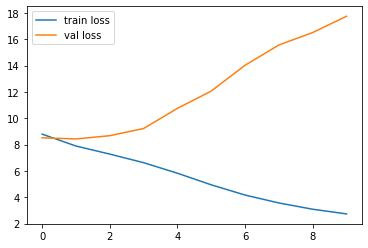

In [19]:
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

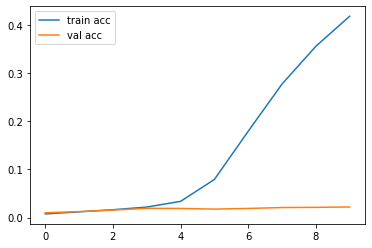

In [20]:
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Model 2

In [23]:
model2 = Sequential()

model2.add(Conv2D(32, (6, 6), activation='relu', strides = (1, 1), input_shape = (32, 32, 3)))
model2.add(BatchNormalization(axis = 3))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu', strides = (1, 1)))
model2.add(AveragePooling2D((3, 3)))

model2.add(Flatten())
model2.add(Dense(512, activation="relu"))
model2.add(Dropout(0.85))
model2.add(Dense(y.shape[1], activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 27, 27, 32)        3488      
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [24]:
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
 12/205 [>.............................] - ETA: 40s - loss: 9.6627 - accuracy: 0.0021

KeyboardInterrupt: 

In [ ]:
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# **Save Model**

In [ ]:
model2.save('happy_whale.h5')

In [41]:
model2_nor = load_model('happy_whale.h5')

# **Score**

In [44]:
results = model2_nor.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 2.24%


# **Submission**

In [30]:
test = os.listdir("../input/happy-whale-and-dolphin/test_images")
print(len(test))

27956


In [33]:
col = ['image']
test_df = pd.DataFrame(test, columns=col)
test_df['predictions'] = ''
#test_df=test_df.head(n=250)

In [37]:
batch_size=5000
batch_start = 0
batch_end = batch_size
L = len(test_df)

while batch_start < L:
    limit = min(batch_end, L)
    test_df_batch = test_df.iloc[batch_start:limit]
    print(type(test_df_batch))
    X = Loading_Images(test_df_batch, test_df_batch.shape[0], "test_images")
    X /= 255
    predictions = model2.predict(np.array(X), verbose=1)
    for i, pred in enumerate(predictions):
        p=pred.argsort()[-5:][::-1]
        idx=-1
        s=''
        s1=''
        s2=''
        for x in p:
            idx=idx+1
            if pred[x]>0.7:
                s1 = s1 + ' ' +  label_encoder.inverse_transform(p)[idx]
            else:
                s2 = s2 + ' ' + label_encoder.inverse_transform(p)[idx]
        s= s1 + ' new_individual' + s2
        s = s.strip(' ')
        test_df.loc[ batch_start + i, 'predictions'] = s
    batch_start += batch_size   
    batch_end += batch_size
    del X
    del test_df_batch
    del predictions
    gc.collect()
    

<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 15ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 15ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 14ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 15ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 3s 16ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/2956 [00:00<?, ?it/s]

93/93 [==============================] - 1s 16ms/step


In [38]:
test_df.to_csv('submission.csv',index=False)
test_df.head()

,image,predictions
0,cd50701ae53ed8.jpg,new_individual 37c7aba965a5 bc1eb2241633 02da0...
1,177269f927ed34.jpg,new_individual 37c7aba965a5 bc1eb2241633 02da0...
2,9137934396d804.jpg,new_individual 37c7aba965a5 02da0e68dccd bc1eb...
3,c28365a55a0dfe.jpg,new_individual 37c7aba965a5 02da0e68dccd bc1eb...
4,1a40b7b382923a.jpg,new_individual 37c7aba965a5 02da0e68dccd bc1eb...
